<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/12_4_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

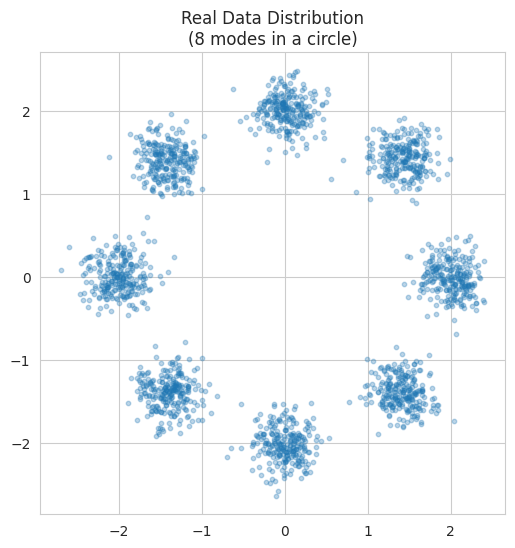

EXPERIMENT 1: MSE Loss vs Adversarial Loss
Training with MSE Loss (No Discriminator)...
Epoch 50/200, Loss: 0.0000
Epoch 100/200, Loss: 0.0000
Epoch 150/200, Loss: 0.0000
Epoch 200/200, Loss: 0.0000

Training with Adversarial Loss (GAN)...
Epoch 50/200, G Loss: 1.6066, D Loss: 1.1068
Epoch 100/200, G Loss: 0.8514, D Loss: 1.2297
Epoch 150/200, G Loss: 1.0902, D Loss: 1.0591
Epoch 200/200, G Loss: 1.1473, D Loss: 1.0982


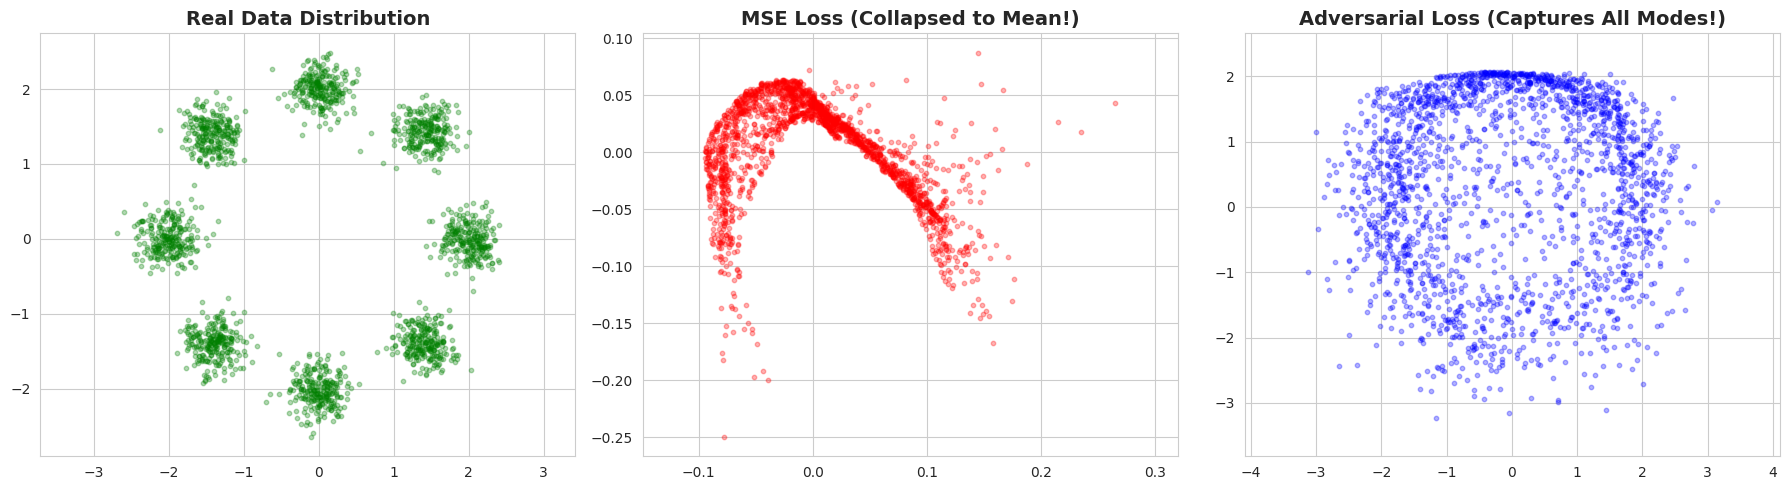


OBSERVATION:
MSE Loss: Collapsed to center (average of all modes)
Adversarial Loss: Captured all 8 modes!

This demonstrates WHY adversarial training is powerful:
- MSE forces generator to output the 'average' sample
- Adversarial loss allows generator to match the full distribution


In [ ]:
"""
GAN Demo: Understanding Adversarial Training
========================================================

This notebook demonstrates:
1. Why adversarial loss is powerful (compare to MSE)
2. Mode collapse in action
3. The training dynamics of GANs
4. Practical MNIST GAN implementation
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

# Set style for nice plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

#==============================================================================
# PART 1: 2D Visualization - Why Adversarial Loss Matters
#==============================================================================

class Simple2DGenerator(nn.Module):
    """Simple generator for 2D data"""
    def __init__(self, latent_dim=2, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # Output 2D points
        )

    def forward(self, z):
        return self.model(z)

class Simple2DDiscriminator(nn.Module):
    """Simple discriminator for 2D data"""
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()

def create_multimodal_data(n_samples=1000, n_modes=8):
    """
    Create multimodal 2D data (circle of Gaussians)
    This will test if GAN can capture all modes!
    """
    angles = np.linspace(0, 2*np.pi, n_modes, endpoint=False)
    radius = 2.0
    std = 0.2

    samples = []
    for angle in angles:
        # Center of this mode
        center_x = radius * np.cos(angle)
        center_y = radius * np.sin(angle)

        # Sample from Gaussian around this center
        n_per_mode = n_samples // n_modes
        mode_samples = np.random.randn(n_per_mode, 2) * std
        mode_samples[:, 0] += center_x
        mode_samples[:, 1] += center_y
        samples.append(mode_samples)

    return torch.FloatTensor(np.vstack(samples))

# Create data
real_data = create_multimodal_data(n_samples=2000, n_modes=8)

# Visualize the data distribution
plt.figure(figsize=(6, 6))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, s=10)
plt.title("Real Data Distribution\n(8 modes in a circle)")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.axis('equal')
plt.grid(True)
plt.show()

#==============================================================================
# COMPARISON: MSE Loss vs Adversarial Loss
#==============================================================================

def train_with_mse_loss(generator, real_data, epochs=200, lr=0.001):
    """
    Train generator to match real data using simple MSE loss
    (Like an autoencoder without the encoder)
    """
    optimizer = optim.Adam(generator.parameters(), lr=lr)
    losses = []

    print("Training with MSE Loss (No Discriminator)...")

    for epoch in range(epochs):
        # Sample noise
        z = torch.randn(len(real_data), 2)

        # Generate fake data
        fake_data = generator(z)

        # MSE loss: try to match distribution
        # Problem: This will average over modes!
        loss = nn.MSELoss()(fake_data.mean(0), real_data.mean(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    return losses

def train_gan(generator, discriminator, real_data, epochs=200, lr=0.0002):
    """
    Train GAN with adversarial loss
    """
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    g_losses = []
    d_losses = []

    print("Training with Adversarial Loss (GAN)...")

    for epoch in range(epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------
        for _ in range(5):  # Train D more frequently for stability
            # Real data
            real_labels = torch.ones(len(real_data))
            real_output = discriminator(real_data)
            d_loss_real = criterion(real_output, real_labels)

            # Fake data
            z = torch.randn(len(real_data), 2)
            fake_data = generator(z).detach()  # Detach!
            fake_labels = torch.zeros(len(fake_data))
            fake_output = discriminator(fake_data)
            d_loss_fake = criterion(fake_output, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        # -----------------
        # Train Generator
        # -----------------
        z = torch.randn(len(real_data), 2)
        fake_data = generator(z)
        fake_output = discriminator(fake_data)

        # Generator wants discriminator to output 1 (thinks it's real)
        g_loss = criterion(fake_output, torch.ones(len(fake_data)))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, G Loss: {g_loss.item():.4f}, "
                  f"D Loss: {d_loss.item():.4f}")

    return g_losses, d_losses

# Train both approaches
print("=" * 60)
print("EXPERIMENT 1: MSE Loss vs Adversarial Loss")
print("=" * 60)

# MSE approach
gen_mse = Simple2DGenerator()
mse_losses = train_with_mse_loss(gen_mse, real_data, epochs=200)

print("\n" + "=" * 60)

# GAN approach
gen_gan = Simple2DGenerator()
disc_gan = Simple2DDiscriminator()
g_losses, d_losses = train_gan(gen_gan, disc_gan, real_data, epochs=200)

#==============================================================================
# Visualize the Results
#==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Real data
axes[0].scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, s=10, c='green')
axes[0].set_title('Real Data Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)
axes[0].axis('equal')
axes[0].grid(True)

# Plot 2: MSE Loss results
z = torch.randn(2000, 2)
fake_mse = gen_mse(z).detach().numpy()
axes[1].scatter(fake_mse[:, 0], fake_mse[:, 1], alpha=0.3, s=10, c='red')
axes[1].set_title('MSE Loss (Collapsed to Mean!)', fontsize=14, fontweight='bold')
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].axis('equal')
axes[1].grid(True)

# Plot 3: GAN results
fake_gan = gen_gan(z).detach().numpy()
axes[2].scatter(fake_gan[:, 0], fake_gan[:, 1], alpha=0.3, s=10, c='blue')
axes[2].set_title('Adversarial Loss (Captures All Modes!)', fontsize=14,
                  fontweight='bold')
axes[2].set_xlim(-3, 3)
axes[2].set_ylim(-3, 3)
axes[2].axis('equal')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("OBSERVATION:")
print("=" * 60)
print("MSE Loss: Collapsed to center (average of all modes)")
print("Adversarial Loss: Captured all 8 modes!")
print("\nThis demonstrates WHY adversarial training is powerful:")
print("- MSE forces generator to output the 'average' sample")
print("- Adversarial loss allows generator to match the full distribution")
print("=" * 60)

#==============================================================================
# PART 2: Demonstrating Mode Collapse
#===================================================================